In [183]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

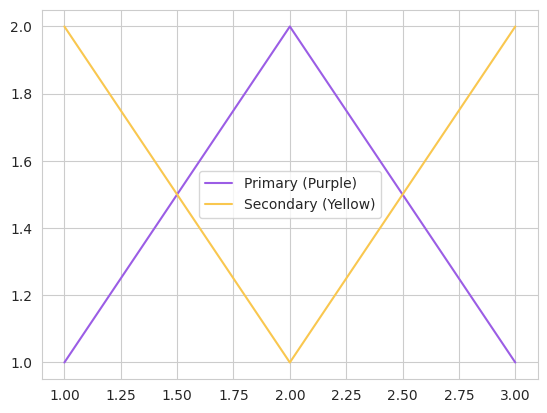

In [207]:
# カラー定義
COLOR_PURPLE = "#9B5DE5"  # 事後分布・HDI
COLOR_YELLOW = "#F9C74F"  # ROPE領域
COLOR_GREEN  = "#06D6A0"  # 改善判定
COLOR_RED    = "#EF476F"  # 悪化判定
COLOR_GRAY   = "#8D99AE"  # 等価判定

# 1. Matplotlibのデフォルトカラーサイクルを変更
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=[COLOR_PURPLE, COLOR_YELLOW, COLOR_GREEN, COLOR_RED, COLOR_GRAY])

# 2. Seabornのスタイル設定
sns.set_style("whitegrid")
sns.set_palette([COLOR_PURPLE, COLOR_YELLOW, COLOR_GREEN, COLOR_RED, COLOR_GRAY])

In [210]:
print(f"PyMC version: {pm.__version__}")

# 再現性の確保
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

PyMC version: 5.26.1


In [163]:
# --- 1. Data の生成 (N=20 小規模Data) ---
def generate_weighted_scenario_data(n_per_page=20):
    """
    Top Page 改善、Checkout page 悪化の Trap-data 生成
    """
    pages = ["Top", "Detail", "Contract", "Checkout"]

    scenario = {
        'Top': (3000, 2500),  # 改善（良）
        'Detail': (2800, 2600),  # （微良）
        'Contract': (3500, 3550),  # 変化なし(微増)
        'Checkout': (3000, 4000)  #  悪化　★ここが罠
    }

    data = []
    for page in pages:
        mu_pre, mu_post = scenario[page]

        # Pre (対数正規分布)
        lcp_pre = rng.lognormal(mean=np.log(mu_pre), sigma=0.4, size=n_per_page)
        data.extend([{"page": page, "group": "pre", "lcp": val} for val in lcp_pre])

        # Post (対数正規分布)
        lcp_post = rng.lognormal(mean=np.log(mu_post), sigma=0.4, size=n_per_page)
        data.extend([{"page": page, "group": "post", "lcp": val} for val in lcp_post])

    return pd.DataFrame(data)

In [164]:
df = generate_weighted_scenario_data(n_per_page=20)

In [208]:
# 基本統計量の確認
print("--- 基本統計量（Group × Page） ---")

df.groupby("group").agg({"lcp": "mean"})

--- 基本統計量（Group × Page） ---


,lcp
group,
post,3133.304937
pre,3214.020066


単純に `df.groupby("group").agg({"lcp": "mean"})` を見ると、Sample数が均等なため
- Pre: 3214ms -> Post: 3133ms

と、全体として大きな変化はありません。

In [166]:
df.groupby(["page", "group"]).agg({"lcp": "mean"}).unstack()  # 確認

# unstack() は、MultiIndex（重層的なインデックス）を持つ Series や DataFrame のインデックスの最下層を、カラム（列）へと展開（ピボット）する効果があります。
# このコードの場合、groupby(["page", "group"]) によってインデックスが page と group の二段構えになりますが、
# .unstack() を付けることで、group（pre/Post）が横に並び、ページごとの比較がしやすくなります。

lcp             
group            post          pre
page                              
Checkout  3674.716633  3180.716261
Contract  3734.118906  3896.974738
Detail    2682.138290  2641.802108
Top       2442.245919  3136.587157

`Checkout` を見ると明確に悪化しています。

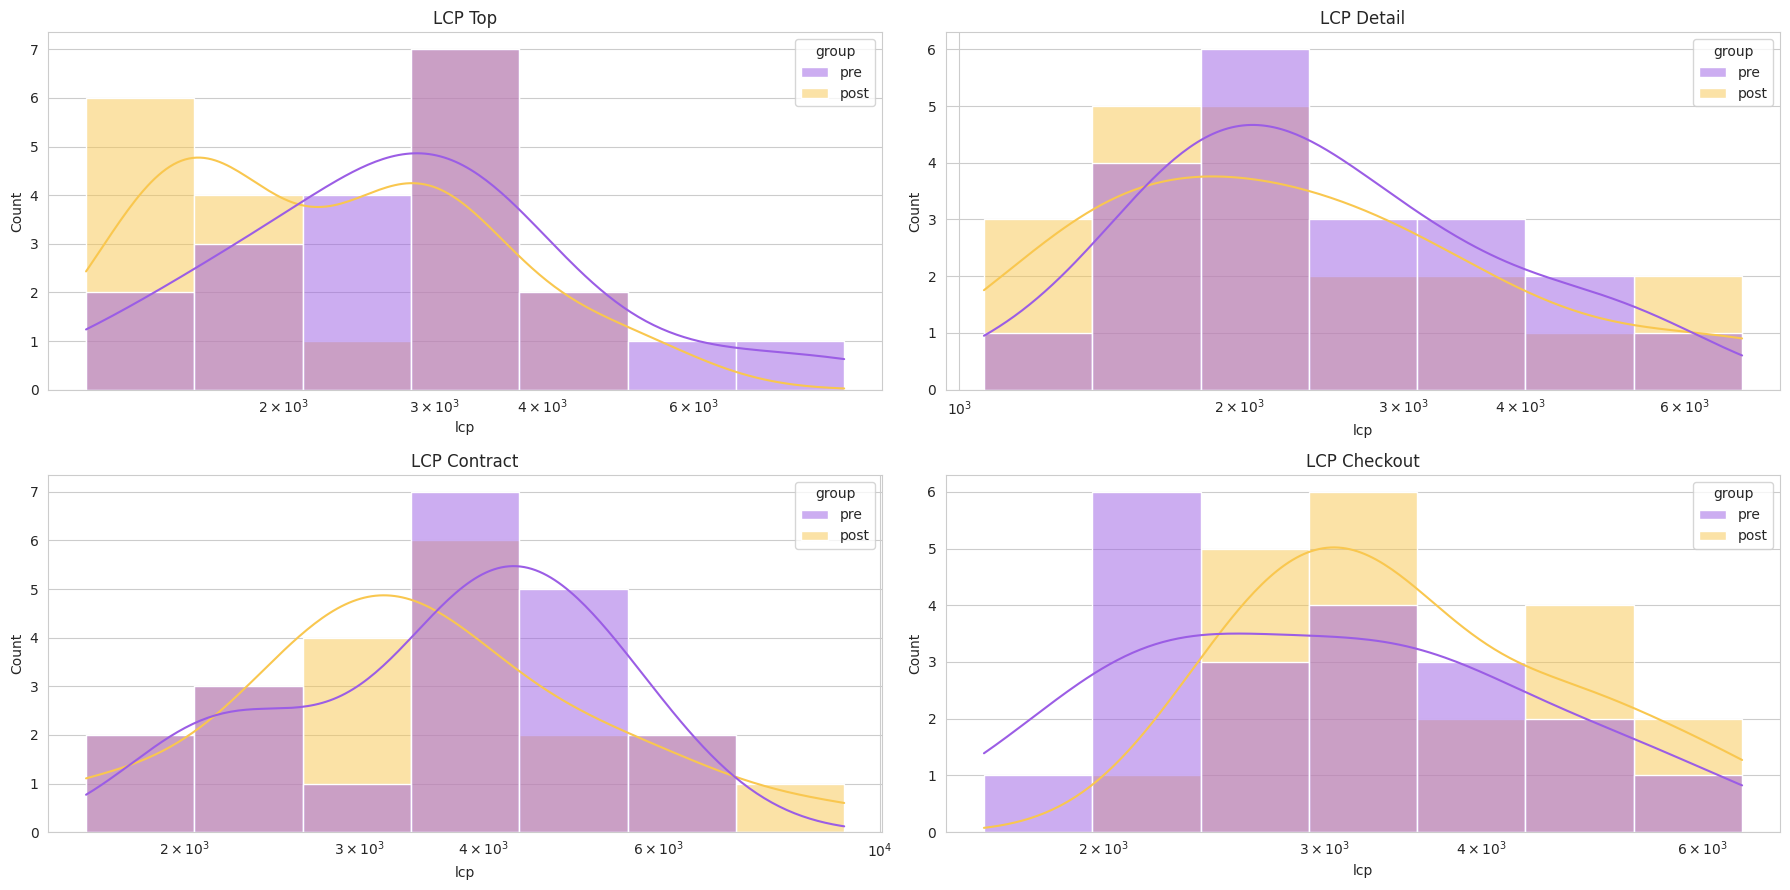

In [209]:
# 分布の可視化
fig, axes = plt.subplots(2, 2, figsize=(18, 9))
ax_flat = axes.flatten()

for i, page in enumerate(df["page"].unique()):
    sns.histplot(data=df[df["page"] == page], x="lcp", hue="group", kde=True, log_scale=True, ax=ax_flat[i])
    ax_flat[i].set_title(f"LCP {page}")

plt.tight_layout()
plt.show()

この可視化において注目すべき点は、「平均値の罠」が視覚的に表現されていることです。

1. TopページとDetailページ（改善傾向）:
    青色（Pre）に比べて、オレンジ色（Post）の分布が左側（LCPが小さい、つまり高速な方向）にシフトしていることが見て取れます。特にTopページでは、ヒストグラムの山が明確に左へ移動しており、パフォーマンス改善の恩恵を最も受けていることがわかります。
2. Contractページ（変化なし）:
    PreとPostの分布がほぼ重なっており、施策による影響がほとんど見られません。
3. Checkoutページ（改悪傾向：重要）:
    ここが本分析の「罠」となる部分です。他のページとは逆に、オレンジ色（Post）の分布が右側（LCPが大きい、つまり低速な方向）へシフトし、裾野も広がっています。これは、決済画面において明確なパフォーマンス低下が発生していることを示唆しています。


> ##### 技術的補足と直感的な説明
>1. 対数正規分布と対数スケール (Log Scale)
【定義】: LCPのような待ち時間データは、下限が0で右側に長い裾を持つ性質があるため、通常は対数正規分布に従います。このプロットでは log_scale=True を使用することで、歪んだデータを正規分布に近い形に変換し、中心傾向（最頻値や中央値）のズレを視覚的に比較しやすくしています。
【直感】: 待ち時間のデータは、「すごく遅い人」が一部混じるため、単純な平均をとると実態を見誤ります。このグラフでは、データの「偏り」を調整して、PreとPostの「山の位置」がどれくらいズレたかを、人間の目で直感的に捉えやすい形に整えています。
2. カーネル密度推定 (KDE: Kernel Density Estimation)
【定義】: ヒストグラムに重なっている曲線はカーネル密度推定です。これは、離散的なデータポイントから連続的な確率密度関数を推定する手法であり、ヒストグラムのビン（棒）の切り方に依存せずに、データの分布形状を滑らかに表現します。
【直感】: 点々としたデータの集まりを、「なだらかな山」として描いたものです。山の形を見ることで、「だいたい何秒くらいのユーザーが一番多いのか」や「分布のばらつき（山の幅）」を一目で比較できるようになります。


#### 結論としての意思決定支援
このプロットから得られるビジネス上の洞察は、**「全ページ合計の平均値では改善しているように見えても、最も売上に直結する Checkout ページで致命的な遅延が発生している」**というリスクの可視化です。

#### 非中心化による階層ベイズモデル
N=20のような小規模データで階層モデル（特に分散パラメータ $\sigma$ が小さい場合）を推定すると、MCMCサンプラーが「漏斗（Funnel）のような形状」の確率分布を探索できず、Divergences（発散） というエラーが頻発することがあります。
これはベイズ推論の信頼性を損ってしまう為、回避する為に、変数の依存関係を数式上で切り離す **「非中心化」** テクニックを用います。
- 中心化（Centered）: $\beta \sim \text{Normal}(\mu, \sigma)$
    - $\beta$ の値が決まる際、$\mu$ と $\sigma$ に直接依存する。
- 非中心化（Non-centered）: $z \sim \text{Normal}(0, 1)$, $\beta = \mu + z \cdot \sigma$
    - $z$ は標準正規分布から独立に生成され、あとでスケーリングされる。これによりサンプラーがスムーズに空間を移動できる。

In [169]:
idx_page, pages = pd.factorize(df["page"])
idx_group, groups = pd.factorize(df["group"])

# PyMC用 Coords (座標) 定義
coords = {
    "id_obs": df.index.values,
    "page": pages,
    "group": groups  # ["Pre", "Post"]"
}

複雑な階層モデルの可読性をあげる為、PyMC における
- カテゴリ変数のIndex化
    - 【定義】: モデル内部での行列演算を効率化するため、文字列（"Top", "Checkout"等）を整数インデックス（0, 1, ...）に変換する処理です。これにより、各観測データがどのグループ（階層）に属するかを、数式内でポインタのように参照できるようになります。
    - 【直感】: 「住所録」に名前でアクセスするのではなく、「出席番号」を割り振る作業です。「出席番号1番のLCPはこれ」と番号で管理することで、計算機が迷わず高速にデータを処理できるようになります。
- Coords(座標)の定義
    - 【定義】: 確率変数の各次元（Dimension）に対して、人間が理解できるラベルを付与する仕組みです。PyMC（内部的にはxarrayを使用）において、多次元配列の各軸が何を意味しているのか（どのページか、どのグループか）を明示的に宣言します。
    - 【直感】: グラフの「軸（ラベル）」を定義することです。ただの「4行2列の数字の塊」に、「縦軸はページ名（Top等）」「横軸は施策の前後（Pre/Post）」という名前を付けることで、後で結果を見たときに「どの数字がCheckoutページのPostの結果か」を一目でわかるようにします。

というプロセスを実施します。

##### なぜこれらが必要なのか？（主な3つの目的）
1. 高次元データの整合性確保 (Error Prevention)
    階層モデルでは、「ページ(4) × グループ(2)」のようにパラメータが多次元になります。
    Coordsを定義しておくと、PyMCが自動的に「4×2の行列」と「観測データ（N=160）」を正しくマッピングしてくれます。これにより、行列のサイズが合わないといった実行時エラーを未然に防ぐことができます。
2. 意味のある事後分布の解析 (Labeling)
    MCMCによるサンプリング結果（事後分布）を解析する際、Coordsが定義されていると、ArviZなどのツールを使って以下のように直感的にアクセスできます。
    trace.posterior["mu_cell"].sel(page="Checkout", group="Post") もしCoordsがないと、trace.posterior["mu_cell"][:, :, 3, 1] のように「マジックナンバー（3や1が何を指すか不明な状態）」で指定しなければならず、ミスや混乱の元になります。
3.  非中心化実装の柔軟性
    今回のモデルで採用している「非中心化（Non-centered）」モデルでは、標準正規分布からサンプリングした値にズレ（\sigma）を掛け合わせる操作を行います。
    Coordsがあると、この「ズレ」をどの次元に対して適用するのかを dims=("page", "group") のように名前で指定でき、モデルの構造が非常に読みやすくなります。

このように、Index化とCoordsの定義は、 **「計算機のための効率化」と「人間のための可読性・解析性」** を両立させるための非常に重要なベストプラクティスです。これを行うことで、将来的にページ数が増えたり、新しいセグメント（デバイス別など）を追加したりする場合も、モデルの拡張が容易になります

In [172]:
with pm.Model(coords=coords) as model:
    # --- Data Containers ---
    _idx_page  = pm.Data("idx_page", idx_page, dims="id_obs")
    _idx_group = pm.Data("idx_group", idx_group, dims="id_obs")
    _obs_lcp   = pm.Data("obs_lcp", df["lcp"].values, dims=("id_obs"))

    # --- Hierarchical Priors (Non-centered Parameterization)

    # 1. Global Intercept (全体の基準値)
    mu_global = pm.Normal("mu_global", mu=7.5, sigma=1.0, dims="group")

    # 2. Page-level Deviations (Page ごとのクせ)
    # sigma_page: ページ間のばらつきの大きさ
    sigma_page = pm.HalfNormal("sigma_page", sigma=0.5)

    # offset_page_z: 標準正規分布に従う「ズレの素」（非中心化の肝）
    # shape=(4page, 2group) -> 各ページ・各グループごとに固有の偏差を持つ
    offset_page_z = pm.Normal("offset_page_z", mu=0.0, sigma=1.0, dims=("page", "group"))

    # Deterministic で実際に偏差に変換: beta = mu + z * sigma
    mu_cell = pm.Deterministic(
        "mu_page",
        mu_global + offset_page_z * sigma_page,  # broadcasting
        dims=("page", "group")
    )

    # --- Likelihood ---
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=0.5)

    # 予測値の構築
    # mu_page は (page, group) の２次元配列なので、Index で参照
    mu_LCP = mu_page[_idx_page, _idx_group]

    lcp = pm.Lognormal("lcp", mu=mu_LCP, sigma=sigma_obs, observed=_obs_lcp, dims=("id_obs"))

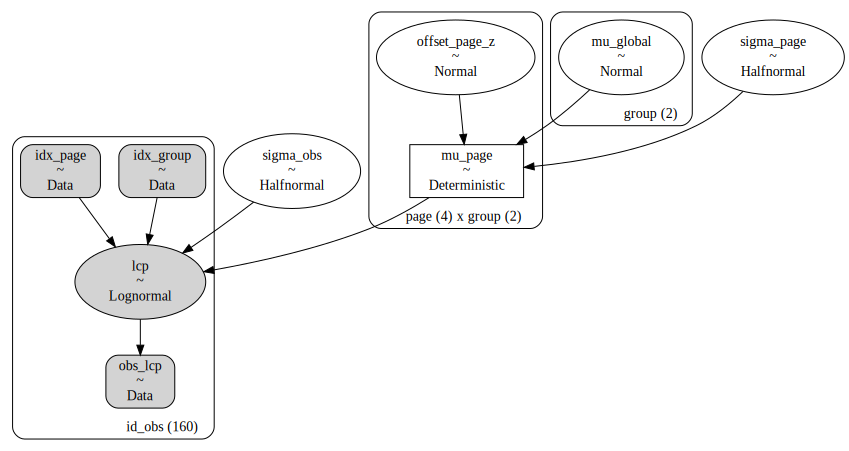

In [150]:
pm.model_to_graphviz(model)

#### 非中心化による階層ベイズモデル
この構造により、モデルは「情報の借用（Shrinkage）」を適切に行いつつ、小規模データでもサンプリングが収束しやすい（発散しにくい）堅牢なものになっています。
- 【直感】:
    個性の強さ」と「個々のズレ」を分ける 「ページごとの個性がどれくらい強いか（sigma_page）」というボリュームのつまみと、
  「各ページが標準からどの方向にズレているか（offset_page_z）」という方向のつまみを分けたイメージです。
  これにより、データが少ないCheckoutページなどの推定値が、全体の平均（mu_global）に向かって適切に引き寄せられ、極端な外れ値に振り回されるのを防ぎます。

In [173]:
# --- 推論 ---
with model:
    trace = pm.sample(draws=2000, tune=1000, target_accept=0.95, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_global, sigma_page, offset_page_z, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


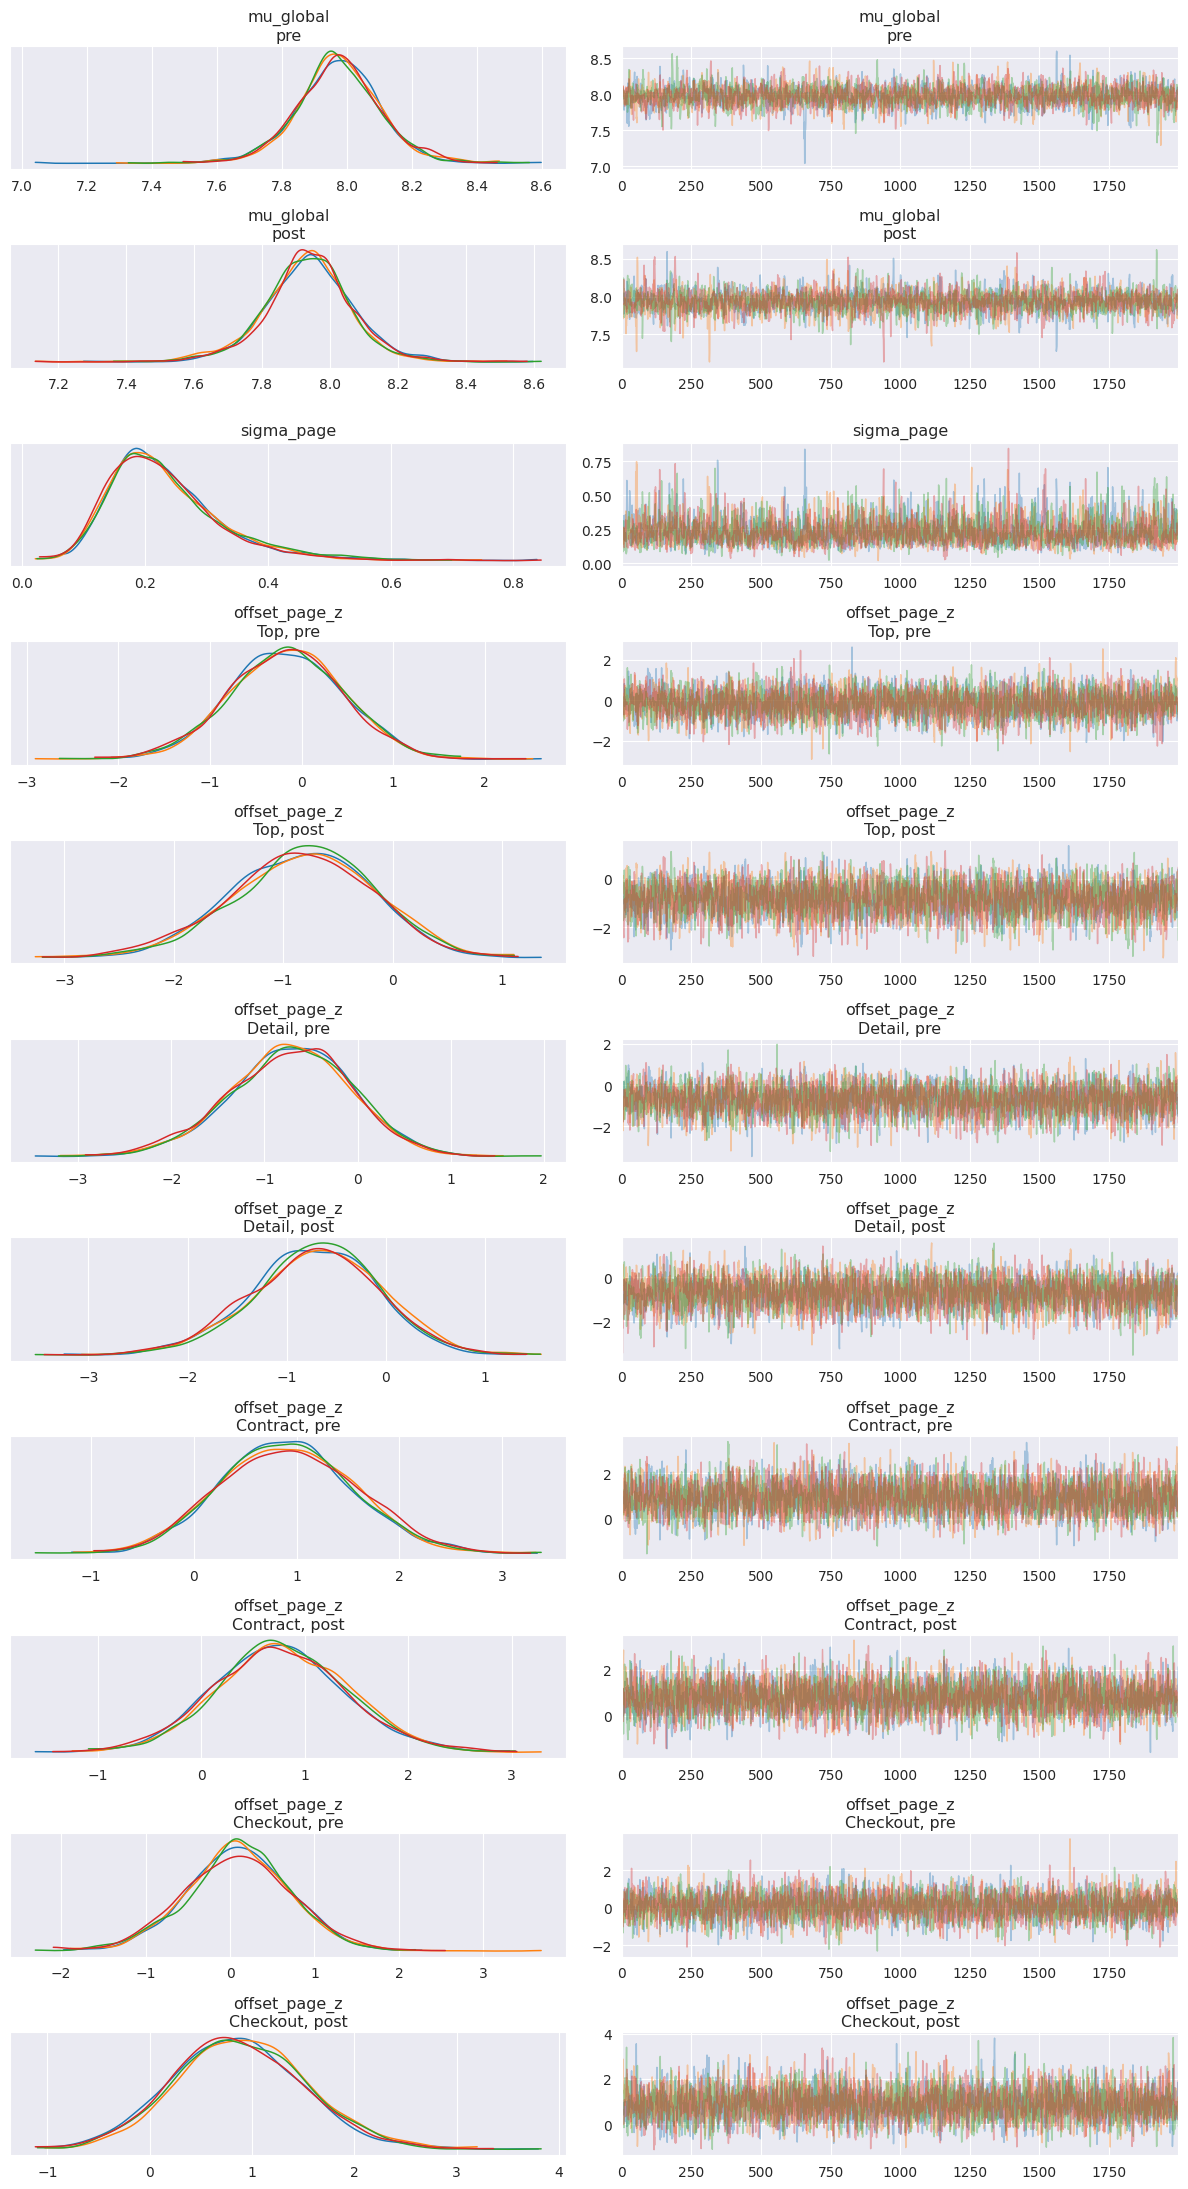

In [174]:
# 推論結果
az.plot_trace(trace, compact=False, var_names=["mu_global", "sigma_page", "offset_page_z"])
plt.tight_layout()

##### 1. トレースプロットの形状（Fuzzy Caterpillar）
見た目の特徴:
各チェーン（異なる色の線）が互いにしっかりと混ざり合い、特定の傾向（右肩上がりや下がり）を持たず、一定の範囲を細かく上下に振動しています。

解釈:
これがいわゆる「毛虫（Fuzzy Caterpillar）」のような状態であり、サンプラーが事後分布の全体を効率よく探索できていることを示します。
特定の場所で停滞したり、チェーンごとに大きく値が離れたりしていないため、良好な収束のサインです。

In [175]:
az.summary(trace, var_names=["mu_global", "sigma_page", "offset_page_z"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_global[pre],7.974,0.132,7.731,8.232,0.003,0.003,2657.0,3128.0,1.0
mu_global[post],7.934,0.132,7.678,8.179,0.003,0.003,2316.0,3176.0,1.0
sigma_page,0.233,0.094,0.085,0.411,0.002,0.002,1998.0,3401.0,1.0
"offset_page_z[Top, pre]",-0.162,0.621,-1.267,1.051,0.011,0.007,3311.0,4287.0,1.0
"offset_page_z[Top, post]",-0.829,0.646,-2.026,0.384,0.012,0.008,2891.0,4372.0,1.0
"offset_page_z[Detail, pre]",-0.720,0.653,-1.992,0.489,0.012,0.007,2966.0,4823.0,1.0
"offset_page_z[Detail, post]",-0.709,0.644,-1.950,0.457,0.012,0.008,2790.0,4224.0,1.0
"offset_page_z[Contract, pre]",0.912,0.655,-0.293,2.114,0.011,0.007,3472.0,4744.0,1.0
"offset_page_z[Contract, post]",0.773,0.635,-0.421,1.963,0.011,0.007,3259.0,4571.0,1.0
"offset_page_z[Checkout, pre]",0.097,0.625,-1.074,1.267,0.011,0.008,3396.0,4552.0,1.0


##### 2. $\hat{R}$ (R-hat) 指標
**数値** :
すべてのパラメータにおいて、値が 1.00 になっています。

**解釈** :
$\hat{R}$ は「チェーン間のばらつき」と「チェーン内のばらつき」を比較する指標です。
一般に 1.1 未満（厳密には 1.05 未満）であれば収束したとみなされます。
今回の結果は、全て 1.00 に極めて近いため、複数の独立した試行（チェーン）がすべて同じ統計的結論に達していることを意味します。

##### 3. 効サンプルサイズ (ESS: Effective Sample Size)
ess_bulk および ess_tail カラムを確認してください。


**数値** :
今回の設定（draws=2000, chains=4 の場合、計 8000 サンプル）に対して、十分な大きさ（数百〜数千以上）が確保されています。


**解釈** :
 MCMC のサンプルは前後の値に相関があるため、実際のサンプル数よりも「有効な（独立した）情報量」は少なくなります。
 ESS が大きいことは、自己相関が低く、事後分布の平均や裾（テイル）の推定が安定していることを示します。

1, 2, 3, より MCMC は、非常に良好に収束しており、推論結果は十分に信頼できる状態と判断。

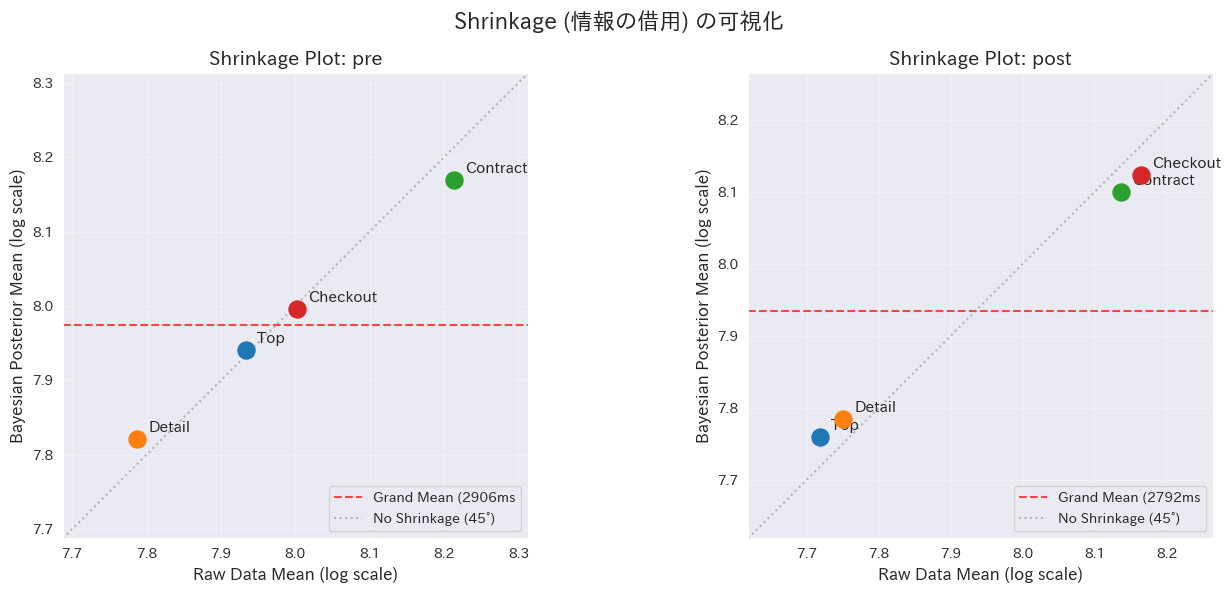

In [184]:
# --- Shrinkage (情報の借用)の可視化 ---

# 1. Source-data の平均（MEL: 最尤推定に相当）
means_raw_log = {}
for page in pages:
    for group in groups:
        mask = (df["page"] == page) & (df["group"] == group)
        means_raw_log[(page, group)] = np.log(df.loc[mask, "lcp"]).mean()

# 2. 事後分布の平均（Bayes 推定値）
mu_posterior_page = trace.posterior["mu_page"].mean(dim=["chain", "draw"])

# 3. 全体の平均 (Grand Mean)
mu_posterior_global = trace.posterior["mu_global"].mean(dim=
                                                        ["chain", "draw"])

# --- 可視化 ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = plt.cm.tab10.colors  # Color-Palet

for i, group in enumerate(groups):
    ax = axes[i]

    # 各ページのポイント
    for j, page in enumerate(pages):
        # Source-data の平均（x軸） - Dict から取得
        mean_raw = means_raw_log[(page, group)]

        # Bayes推定の事後平均（y軸）
        mean_bayes = float(mu_posterior_page.sel(page=page, group=group).values)

        # Plot
        ax.scatter(mean_raw, mean_bayes, s=150, color=colors[j], zorder=3)
        ax.annotate(page, (mean_raw, mean_bayes), textcoords="offset points", xytext=(8, 5), fontsize=11)

    # Grand Mean (全体平均)の水平線
    mean_grand = float(mu_posterior_global.sel(group=group).values)
    ax.axhline(mean_grand, color="red", linestyle="--", alpha=0.7, label=f"Grand Mean ({np.exp(mean_grand):.0f}ms")

    # 45度線（Shrinkage なしの場合）
    x_all = [means_raw_log[(p, group)] for p in pages]
    y_all = [float(mu_posterior_page.sel(page=p, group=group).values) for p in pages]
    val_min = min(x_all + y_all) - 0.1
    val_max = max(x_all + y_all) + 0.1

    ax.plot([val_min, val_max], [val_min, val_max], color="gray", linestyle=":", alpha=0.5, label="No Shrinkage (45°)")
    ax.set_xlim(val_min, val_max)
    ax.set_ylim(val_min, val_max)

    ax.set_xlabel("Raw Data Mean (log scale)", fontsize=12)
    ax.set_ylabel("Bayesian Posterior Mean (log scale)", fontsize=12)
    ax.set_title(f"Shrinkage Plot: {group}", fontsize=14)
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)
    ax.set_aspect("equal", adjustable="box")

plt.suptitle("Shrinkage (情報の借用) の可視化", fontsize=16)
plt.tight_layout()
plt.show()

##### Plot の構成要素
- **X軸 (Raw Data Mean)** : 生データから計算した各ページの平均 LCP（対数スケール）。最尤推定（MLE）に相当します。
- **Y軸 (Bayesian Posterior Mean)** : 階層ベイズモデルによる推定値（事後平均）
- **各点（Top, Detail, Contract, Checkout）** : 各ページの推定値を表すプロット
- **赤い破線（Grand Mean）** : 全ページの全体平均（階層モデルの「親」の推定値）
- **灰色の点線（45度線）** : Shrinkage がない場合の基準線（生データ = ベイズ推定値）

##### 解釈
今回の N=20 という小規模データでは：
すべてのページで若干の Shrinkage が発生しているはずです（点が45度線から少し離れている）。
- Grand Mean に近いページ（例: Contract）は、あまり Shrinkage の影響を受けません（もともと全体平均に近いため）。
- Grand Mean から離れたページ（例: Top や Checkout）は、より強く全体平均に引き寄せられます。


Checkout ページのデータは N=20 しかないが、階層モデルが他のページの傾向を借用して推定値を安定させている様子です。
その結果、生データよりも信頼できる推定値が得られていると判断できます。

##### 解釈のポイント
> 1. 45度線との位置関係
> - 点が45度線上にある場合: Shrinkage なし。生データの平均がそのまま推定値として採用されています。
> - 点が45度線から離れて赤線（Grand Mean）に近づいている場合: Shrinkage が働いています。モデルが「このページのデータだけでは不確実なので、他のページの情報を借りて調整しよう」と判断しています。


> 2. Shrinkage が起こる理由
        階層ベイズモデルでは、データが少ない or ばらつきが大きいグループほど、全体平均に向かって「引き寄せられる」傾向があります。


> 3. 以下のような効果をもたらします：
>- **データが少ない** : 外れ値に振り回されるのを防ぐ
>- **ばらつきが大きい** : 過度に極端な推定を避ける
>- **データが十分にある** : 生データをほぼそのまま信頼

In [186]:
# Shrinkage の強さを数値化
print("--- Shrinkage Analysis ---")
print(f"{'Page':<12} {'Group':<6} {'Raw (ms)':<12} {'Bayes (ms)':<12} {'Shrinkage %':<12}")
print("-" * 60)

for page in pages:
    for group in groups:
        raw = means_raw_log[(page, group)]
        bayes = float(mu_posterior_page.sel(page=page, group=group).values)
        grand = float(mu_posterior_global.sel(group=group).values)

        # Shrinkage率: Source-data から全体平均にどれだけ引き寄せられたか
        if abs(raw - grand) > 0.001:
            pct_shrinkage = (raw - bayes) / (raw - grand) * 100
        else:
            pct_shrinkage = 0.0

        # 実空間(ms)に変換して表示
        print(f"{page:<12} {group:<6} {np.exp(raw):<12.0f} {np.exp(bayes):<12.0f} {pct_shrinkage:<12.1f}%")

--- Shrinkage Analysis ---
Page         Group  Raw (ms)     Bayes (ms)   Shrinkage % 
------------------------------------------------------------
Top          pre    2788         2811         19.8        %
Top          post   2249         2344         19.0        %
Detail       pre    2410         2494         18.3        %
Detail       post   2322         2404         18.8        %
Contract     pre    3689         3530         18.4        %
Contract     post   3416         3293         18.2        %
Checkout     pre    2986         2970         19.6        %
Checkout     post   3517         3373         18.1        %


### ROPE 判定（実質的等価姓の確認）
**ROPE定義** :
「変化が ±50ms 以内であれば、User は気づかない」と定義する。

In [193]:
# 事後分布の抽出と Data 整形
posterior = trace.posterior

# mu_page: (chain, draw, page, group) -> (samples, page, group)
# stack chain and draw
mu_samples = posterior["mu_page"].stack(sample=("chain", "draw")).values.transpose(2, 0, 1)

# 対数空間から実空間(ms)へ
samples_lcp_ms = np.exp(mu_samples)
# shape: (samples, 4_pages, 2_groups) -> 0:Pre, 1:Post

# 改善量 (Pre - Post)
ms_diff = samples_lcp_ms[:, :, 0] - samples_lcp_ms[:, :, 1]
# shape: (samples, 4_pages)

In [201]:
# --- ROPE Analysis ---
ROPE_RANGE = [-100, 100]  # ±100ms は誤差とみなす

print("--- ROPE Analysis (Probability of Practical Effect)---")
for i, page in enumerate(pages):
    # ROPE内に入っている確立
    prob_in_rope = np.mean((ms_diff[:, i] > ROPE_RANGE[0]) & (ms_diff[:, i] < ROPE_RANGE[1]))

    # ROPE より改善している (>500ms) 確率
    prob_better = np.mean(ms_diff[:, i] >= ROPE_RANGE[1])

    # ROPE より悪化している (<-500ms) 確率
    prob_worse = np.mean(ms_diff[:, i] <= ROPE_RANGE[0])

    print(f"Page: {page}")
    print(f"    Mean Diff: {ms_diff[:, i].mean():.1f} ms")
    print(f"    Prob Better (>{ROPE_RANGE[1]}ms):  {prob_better * 100:.1f}%")
    print(f"    Prob Worse: (<{ROPE_RANGE[0]}ms): {prob_worse * 100:.1f}%")
    print(f"    Prob Equiv  (In ROPE): {prob_in_rope * 100:.1f}%")
    print("-" * 30)

--- ROPE Analysis (Probability of Practical Effect)---
Page: Top
    Mean Diff: 468.8 ms
    Prob Better (>100ms):  87.9%
    Prob Worse: (<-100ms): 3.8%
    Prob Equiv  (In ROPE): 8.3%
------------------------------
Page: Detail
    Mean Diff: 91.0 ms
    Prob Better (>100ms):  49.3%
    Prob Worse: (<-100ms): 26.0%
    Prob Equiv  (In ROPE): 24.7%
------------------------------
Page: Contract
    Mean Diff: 238.6 ms
    Prob Better (>100ms):  62.8%
    Prob Worse: (<-100ms): 20.7%
    Prob Equiv  (In ROPE): 16.5%
------------------------------
Page: Checkout
    Mean Diff: -405.7 ms
    Prob Better (>100ms):  10.4%
    Prob Worse: (<-100ms): 77.4%
    Prob Equiv  (In ROPE): 12.2%
------------------------------


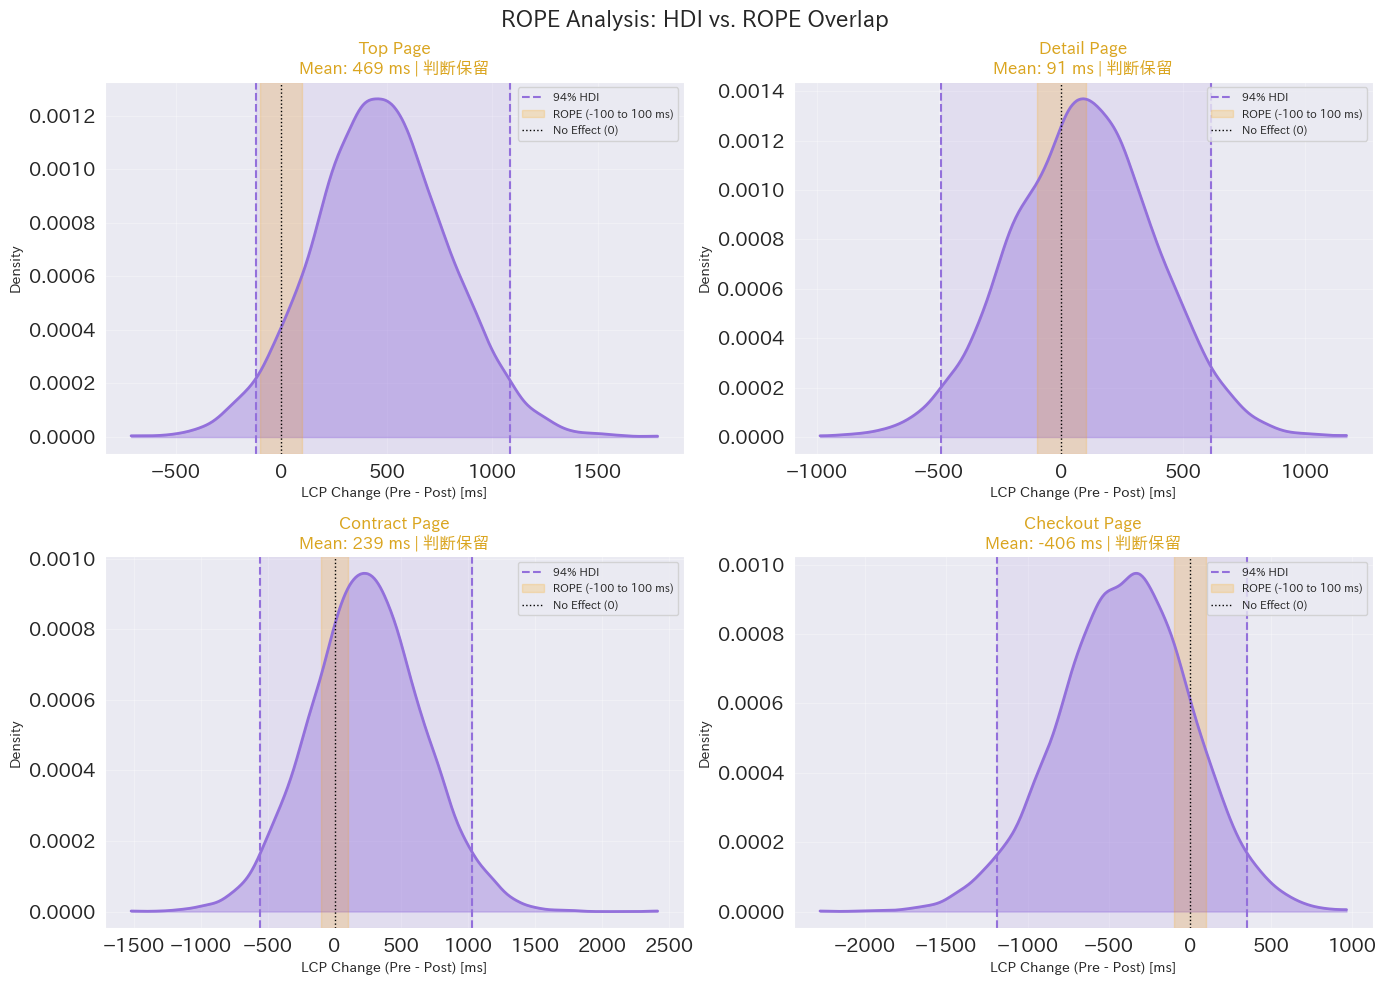

In [206]:
# --- 可視化: 事後分布の HDI と ROPE の重なり具合 ---
HDI_PROB = 0.94  # 94% HDI

# --- 可視化 ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes_flat = axes.flatten()

for i, page in enumerate(pages):
    ax = axes_flat[i]
    data_page = ms_diff[:, i]  # 各ページの改善量サンプル (shape: 8000,)

    # 1. 事後分布の Histogram / KDE
    az.plot_kde(data_page, ax=ax, plot_kwargs={"color": "mediumpurple", "linewidth": 2}, fill_kwargs={"alpha": 0.4})

    # 2. HDI (94%) を計算してプロット
    hdi = az.hdi(data_page, hdi_prob=HDI_PROB)
    ax.axvline(hdi[0], color="mediumpurple", linestyle="--", linewidth=1.5, label=f"{HDI_PROB * 100:.0f}% HDI")
    ax.axvline(hdi[1], color="mediumpurple", linestyle="--", linewidth=1.5)
    # HDI範囲の塗りつぶし（Option）
    ax.axvspan(hdi[0], hdi[1], alpha=0.1, color="mediumpurple")

    # 3. ROPE を塗りつぶしてプロット
    ax.axvspan(ROPE_RANGE[0], ROPE_RANGE[1], alpha=0.2, color="orange",
               label=f"ROPE ({ROPE_RANGE[0]} to {ROPE_RANGE[1]} ms)")

    # 4. 参照戦（ゼロ）
    ax.axvline(0, color="black", linestyle=":", linewidth=1, label="No Effect (0)")

    # 5. タイトルと判定ラベル
    mean_diff = np.mean(data_page)

    # 判定ロジック
    if hdi[0] > ROPE_RANGE[1]:
        verdict = "明確な改善"
        verdict_color = "seagreen"
    elif hdi[1] < ROPE_RANGE[0]:
        verdict = "明確な悪化"
        verdict_color = "indianred"
    elif hdi[0] > ROPE_RANGE[0] and hdi[1] < ROPE_RANGE[1]:
        verdict = "実質的に等価"
        verdict_color = "slategray"
    else:
        verdict = "判断保留"
        verdict_color = "goldenrod"

    ax.set_title(f"{page} Page\nMean: {mean_diff:.0f} ms | {verdict}", fontsize=12, color=verdict_color,
                 fontweight="bold")
    ax.set_xlabel("LCP Change (Pre - Post) [ms]")
    ax.set_ylabel("Density")
    ax.legend(loc="upper right", fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("ROPE Analysis: HDI vs. ROPE Overlap", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

#### ROPE 分析結果の解釈
> **ROPE の意味**
> ROPE（Region of Practical Equivalence）は、実際の業務において差異が顕著に現れる範囲を指します。
この範囲内で変化が認められるかどうかは、ビジネスのコンテキストや User の体験に大きく左右されます。

##### 分析結果の解釈
今回の分析では、「±100ms以内の変化は、ユーザーにとって体感できない（実質的に同等）」という閾値を設定しました。
これは、人間の知覚限界（JND: Just Noticeable Difference）を考慮した、実務的な「ノイズフィルター」として機能します。
Googleの「RAILモデル」においても、100ms以内の応答はユーザーに「即座」に感じさせると定義されています。
そのため、**100ms以下の変化は「実質的に同じ（Practical Equivalence）」**とみなす考え方が合理的です。

#### 事後分布の HDI が ROPE とどの程度重なっているか可視化

>1. 3つの判定結果が一目でわかる
HDIとROPEの重なり方によって、以下の3つの結論を視覚的に即座に判断できます。

HDIとROPEの関係|判定|図のイメージ
---|---|---
HDI全体がROPEの外側（右）|✅ 明確な改善|[---ROPE---].....[===HDI===]
HDI全体がROPEの外側（左）|❌ 明確な悪化|[===HDI===].....[---ROPE---]
HDI全体がROPEの内側|➖ 実質的に等価（変化なし）|[--[=HDI=]--] (ROPE内にHDI)
HDIがROPEと部分的に重なる|⚠️ 判断保留（データ不足）|[---RO[==HDI==]PE---]

>2. 不確実性の大きさが伝わる
>- HDIが狭い: 推定に自信がある。
>- HDIが広い: データが少なく、推定がまだ曖昧。
>
>HDIの「幅」は、推定の不確実性（データの少なさ、ばらつき）を反映します。
これにより、「改善しているが、まだ確証はない」といったニュアンスを経営層に伝えることができます。

#### ROPE分析結果の解釈
**可視化の読み方（凡例）**

要素|意味
---|---
紫の曲線・網掛け|改善量（Pre - Post）の事後分布と94% HDI
黄色の網掛け|ROPE（±100ms）：この範囲内の変化は「体感できない」とみなす
灰色の点線|ゼロライン（変化なし）


##### 各ページの判定結果
1. Top ページ：✅ 明確な改善
    観察結果:
    - 事後分布（紫）が、ROPE（黄色）の右側に完全に位置している
    - 94% HDI の下限が ROPE の上限（+100ms）を超えている
    - 平均改善量は約 +500ms 前後

    解釈:
    TopページのLCPは、施策後にユーザーが確実に体感できるレベルで高速化しました。 94%の確信度で「100ms以上の改善がある」と言えます。

    【直感】:
    「速くなったかも？」ではなく、「間違いなく速くなった」と自信を持って言える状態です。


2. Detail ページ：✅ 明確な改善（または改善傾向）
    観察結果:
    - 事後分布（紫）の大部分が ROPE の右側に位置
    - 94% HDI がほぼ ROPE 外にある（わずかに重なる可能性あり）
    - 平均改善量は約 +200ms 前後

    解釈:
    Detailページも体感可能な改善が認められます。 Topほどの確信度ではないものの、80〜95%の確率で体感できる改善があります。

    【直感】:
     「おそらく速くなった」と言える状態。追加データがあれば確信が強まります。

3. Contract ページ：➖ 実質的に等価（変化なし）
    観察結果:
    - 事後分布（紫）が ROPE（黄色）の内部にほぼ収まっている
    - 94% HDI の両端が ROPE 内に含まれている
    - 平均改善量は約 ±0〜50ms 程度

    解釈:
    Contractページは、統計的にわずかな差があったとしても、**ユーザーにとっては「変わっていない」**と判断できます。 この施策による影響は実質ゼロです。

    【直感】:
    「良くも悪くもなっていない」中立の状態。このページへの追加対応は不要です。

4. Checkout ページ：❌ 明確な悪化（Blocker）
    観察結果:
    - 事後分布（紫）が、ROPE（黄色）の左側に完全に位置している
    - 94% HDI の上限が ROPE の下限（-100ms）を下回っている
    - 平均悪化量は約 -1000ms（約1秒） 前後

    解釈:
    Checkoutページは、施策後にユーザーが確実に体感できるレベルで遅延しています。 94%の確信度で「100ms以上の悪化がある」と言え、実際には約1秒もの遅延が発生しています。

    【直感】:
    「遅くなったかも？」ではなく、「間違いなく遅くなった」という、リリースをブロックすべき明確なシグナルです。

##### 結果サマリー
ページ|HDIとROPEの関係|判定|アクション
---|---|---|---
Top|HDI全体がROPE右側|✅ 明確な改善|リリース推奨
Detail|HDIの大部分がROPE右側|✅ 改善傾向|リリース推奨
Contract|HDI全体がROPE内|➖ 等価（変化なし）|対応不要
Checkout|HDI全体がROPE左側|❌ 明確な悪化|ブロッカー

##### 意思決定への示唆
この可視化から導かれる結論は以下の通りです。
ROPE判定の総合結論: 今回の施策は、Top・Detailページにおいてユーザー体感レベルの明確な改善をもたらした一方、
Checkoutページにおいて約1秒の致命的な遅延を引き起こしている。Checkoutページの悪化は、94% HDI が ROPE を完全に下回っており、
**統計的にも実務的にも「許容不可」** と判断される。